In [2]:
from IPython.display import display, Math, Latex

# Libraries you might need
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns

In [4]:
# You can use this function for plotting raster plots (spikes), or you can use your own defined function
def raster(event_times_list, color='k', t_min= 0., t_max=10., ax=None):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    https://scimusing.wordpress.com/2013/05/06/making-raster-plots-in-python-with-matplotlib/
    """
    if ax is None:
        ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        ax.vlines(trial, ith + .5, ith + 1.5, color=color)
    ax.set_ylim(.5, len(event_times_list) + .5)
    ax.set_yticks([])
    ax.set_ylabel('Spike train')
    ax.set_xlim((t_min, t_max))
    ax.set_xlabel('Time [s]')
    return ax

### Homework 2

__1. Generation of inhomogeneous Poisson process__. Consider an inhomogeneous Poisson process with an instantaneous firing rate $\lambda: \mathbb{R} \to \mathbb{R}^+$ such that $\lambda(t) = \lambda_{max} \sigma(t)$ with sigmoid function $\sigma(t) = \frac1{1 + e^{-t}}$, where $t$ is measured in seconds, $\lambda$ in Herz [Hz].

In exercise (a) - (d), generate $N = 100$ spike trains for $\lambda_{max} = 100$ Hz. Plot the raster plot, the numeric approximation of the rate and for comparison the analytic rate given in the exercise.
A numeric approximation of the rate $\tilde{\lambda}$ can be computed by binning the data into 100 bins on the interval $[t_\min, t_\max]$ for each spike train (bin size $\Delta t = \frac{t_\max-t_\min}2$) and computing the number of spikes in all spike trains within the bin, devided by $N$ and the bin size: $\tilde\lambda = \frac{\#spikes}{N \cdot \Delta t}$.

*Hint: Compute the analytical integral of the rate function. Write a function both for the rate function and its integral.*

*Useful integrals for all exercises (including exercise 2)*
\begin{equation*}
\begin{split}
\int \sigma(t) dt
 &= \ln(1 + e^t) + c, \qquad &c \in \mathbb{R} \\
\int \sigma(t)^2 dt
&= \frac1{1 + e^t} + \ln(1 + e^t) + c, \qquad &c \in \mathbb{R}
\end{split}
\end{equation*}

In [5]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def rate(t, rate_max):
    return rate_max * sigmoid(t)

def indefinite_integral(t, rate_max):
    return rate_max * np.log(1 + np.exp(t))

def rate_integral(t_min, t_max, rate_max):
    return indefinite_integral(t_max, rate_max) - indefinite_integral(t_min, rate_max)

rate_max = 100
n_trials = 100
t_min = -5
t_max = 5
bins_count = np.linspace(t_min, t_max, 101)
bin_size = bins_count[1] - bins_count[0]

__a) Temporal distribution method:__ As in the lecture: first find number of spikes $k$ by drawing from Poisson distribution with parameter $\mu = \int_{t_\min}^{t_\max} \lambda(t) dt $, and then draw spike times using a density function $\lambda(t)/\mu$. _(2 points)_

*Hint: Choose an appropriate method for drawing from an arbitrary probability density, e.g., rejection sampling.*

In [27]:
def rejection_sampling(pdf, xmin, xmax, ymax, num_samples):
    samples = []
    while len(samples) < num_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(0, ymax)
        if y < pdf(x):
            samples.append(x)
    return np.array(samples)

In [28]:
def density_function(t):
    return rate(t, rate_max) / mu

In [41]:
np.random.seed(54165)
mu = rate_integral(t_min, t_max, rate_max)

spike_trains = []
for i in range(n_trials):
    k = np.random.poisson(mu)
    spike_times = rejection_sampling(density_function, t_min, t_max, rate_max, k)
    spike_trains.append(spike_times)

In [83]:
# Compute the numeric approximation
numeric_rate = np.zeros(len(bins_count) - 1)

for spike_train in spike_trains:
    hist, _ = np.histogram(spike_train, bins = bins_count)
    numeric_rate += hist / n_trials / bin_size

# Compute the analytical solution
t_values = np.linspace(t_min, t_max, len(bins_count))
analytical_rate = rate(t_values, rate_max)

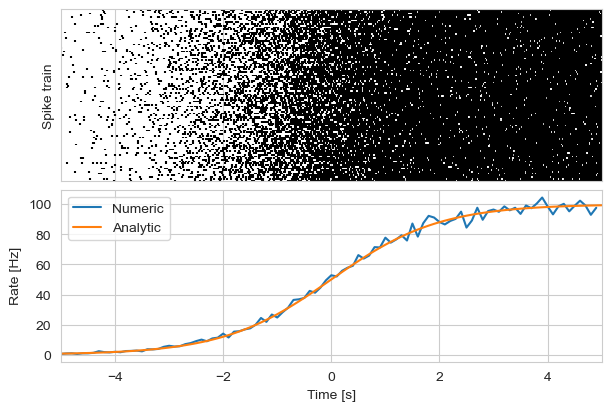

In [84]:
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (6, 4), sharex = True, constrained_layout = True)

raster(spike_trains, t_min = t_min, t_max = t_max, ax = axs[0])
axs[0].set_xlabel("")

axs[1].plot(bins_count[ :-1 ], numeric_rate, label = "Numeric")
axs[1].plot(t_values, analytical_rate, label = "Analytic")
axs[1].legend()
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Rate [Hz]")

plt.show()

__b) Bernoulli method:__ Discretize time into $m$ bins. For each bin $i = 1, \ldots, m$ draw a sample $k_i$ from a Poisson spike count distribution in that bin (Poisson distribution with the parameter equal to integral of the $\lambda(t)$ over the bin). Generate a single spike in each bin with $k_i > 0$ drawing its time-stamp from uniform distribution within this bin. Generate rasters and estimated rate for $m = 10, \: 100, \: 1000, \: 10000.$ _(2 points)_

*Note: The bin count for computing a numerical approximation of the rate is still the same as above.*

In [38]:
def numeric_approximation(bins, spike_trains):
    numeric_rate = np.zeros(len(bins) - 1)
    n_trials = len(spike_trains)
    bin_size = bins[ 1 ] - bins[ 0 ]

    for spike_train in spike_trains:
        hist, _ = np.histogram(spike_train, bins = bins)
        numeric_rate += hist / n_trials / bin_size
    
    return numeric_rate

In [45]:
def analytical_approximation(bins, rate_max):
    return rate(bins, rate_max)

In [50]:
def bernoulli_spikes(n_bins, n_trials, t_min, t_max, rate_max):
    bins = np.linspace(t_min, t_max, n_bins + 1)
    spike_trains = []

    for j in range(n_trials):
        spike_times = []
        for i in range(n_bins):
            mu = rate_integral(bins[ i ], bins[ i + 1 ], rate_max) # integral of the rate function over the bin
            k = np.random.poisson(mu)

            if k > 0:
                spike_times.append(np.random.uniform(low = bins[ i ], high = bins[ i + 1 ]))

        spike_trains.append(spike_times)
    
    return spike_trains

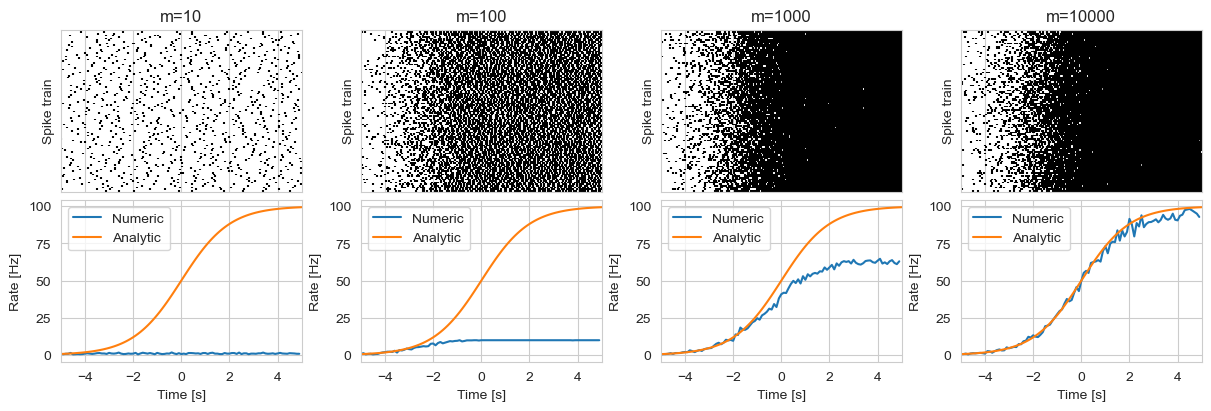

In [75]:
analytical_rate = analytical_approximation(bins = bins_count, rate_max = rate_max)

ms = [ 10, 100, 1000, 10_000 ]

_, axs = plt.subplots(ncols = len(ms), nrows = 2, figsize = (3 * len(ms), 4), sharex = True, constrained_layout = True)

for i, m in enumerate(ms):
    spike_trains = bernoulli_spikes(n_bins = m, n_trials = n_trials, t_min = t_min, t_max = t_max, rate_max = rate_max)
    numeric_rate = numeric_approximation(bins = bins_count, spike_trains = spike_trains)

    raster(spike_trains, t_min = t_min, t_max = t_max, ax = axs[0][i])
    axs[0][i].set_xlabel("")
    axs[0][i].set_title(f"m={m}")
    
    axs[1][i].plot(bins_count[ :-1 ], numeric_rate, label = "Numeric")
    axs[1][i].plot(bins_count, analytical_rate, label = "Analytic")
    axs[1][i].legend()
    axs[1][i].set_xlabel("Time [s]")
    axs[1][i].set_ylabel("Rate [Hz]")

__c) Thinning method:__ First generate a spike train from a Poisson process of rate $\lambda_{max}$ and then iterate through all spikes $l = 1, \ldots, k$ and randomly delete them with probability $1 - \lambda(t^\star_l) /\lambda_{max}$, where $t^\star_l$ is a time point of the $l$-th spike (before thinning). _(2 points)_

In [ ]:
def poisson_spike_train(tau, t_min, t_max, n_trials):
    return

In [ ]:
# compute...

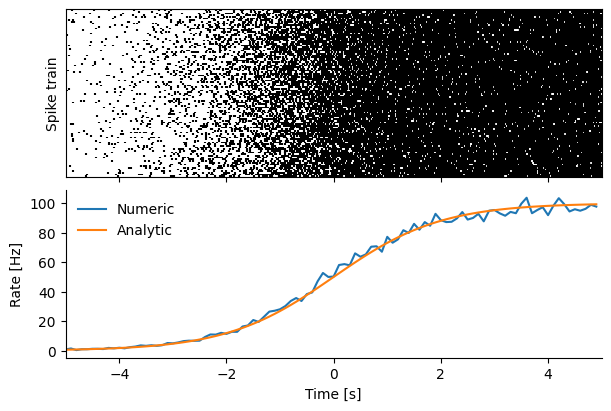

In [ ]:
# plot ...

__d) Renewal and time rescaling method:__ Compute $\mu(t) = \int_{t_\min}^t \lambda(s) ds$. Generate a spike train for a homogeneous Poisson process with rate $1$ on an interval $[0,\mu(t_\max)]$ (using inter-spike interval distribution as in the previous homework). Resulting spike times we call $s_l^\star$. We can then find corresponding pre-images $t_l^\star = \mu^{-1}(s_l^\star) \in [t_\min,t_\max].$ _(2 points)_

*Hint: Invert $\mu(t)$ analytically and write a function. Of course, you can use any tools that you want. Remember to write your solution concisely including necessary intermediate steps.*

**Answer:**

Inverting analytically ...

In [ ]:
def inverse_integral(s, t_min, t_max, rate_max):
    return

In [ ]:
# compute ...

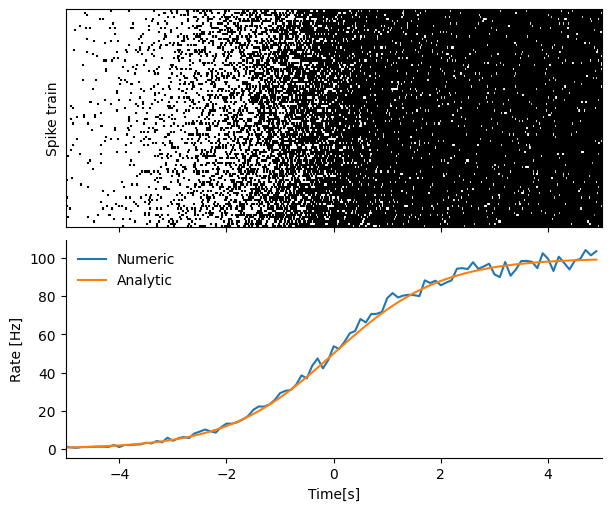

In [ ]:
# plot ...

__2. Variance of the firing rate a)__. Determine the variance of the firing rate (across the bins) using $b = 10, \: 50, \:100$ bins from spike trains generated by method 1.a) using the law of total variance  _(2 points)_

**Answer:**

Formulas I need ...

In [ ]:
# compute and print my solution

n_bin=10
mean spike counts = 500.99
var of spike counts = 1881.9570370370368
var of firing rate = 183185.80370370366
--------------------
n_bin=50
mean spike counts = 503.3
var of spike counts = 73.32558933777592
var of firing rate = 158148.9733444398
--------------------
n_bin=100
mean spike counts = 496.82
var of spike counts = 20.25758187940006
var of firing rate = 152893.8187940006
--------------------


__2. Variance of the firing rate b)__. Compare results from 2.a) with analytical variance of the rate. To compute the analytical variance use the true formula for the time-dependent rate  $\lambda(t) = \lambda_{max} \sigma(t)$ and treat it as a random variable for the time $t$ uniformly distributed in $[t_\min,t_\max]$. \\
_(2 points)_

**Answer:**

...

So variance is
\begin{equation*}
\begin{split}
Var(\lambda)
&= ... \\
&\approx 15134
\end{split}
\end{equation*}